# Pronósticos usando Deep Learning

Contexto bla bla bla


The UCI Electricity Load Diagrams Dataset, containing the
electricity consumption of 370 customers – aggregated on an hourly level as
in [32]. In accordance with [9], we use the past week (i.e. 168 hours) to
forecast over the next 24 hours.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

In [2]:
#df.sort_values(by = 'date')[df.hour == 0].groupby('date').head(1).date.values.tolist()

In [3]:
tf.__version__

'2.3.1'

## Carga de Información

In [4]:
#df = df[df.categorical_id == 'MT_353']
df = pd.read_csv('data/electricity.csv')

In [5]:
df = df.groupby('categorical_id').tail(24*7*4*2)

In [6]:
df = df.sort_values(by = ['categorical_id', 'date'])

In [7]:
#df['lag_usage'] = df.groupby('categorical_id').power_usage.shift(24)

In [8]:
#df['D_usage'] = df['power_usage'] - df['lag_usage']

In [9]:
#df["mean_usage"] = df.groupby(['categorical_id', 'hour']).power_usage.transform(np.mean)
#df['deseasonalized_usage'] = df['power_usage']/df['mean_usage']

In [10]:
df.head()

,power_usage,t,days_from_start,categorical_id,date,id,hour,day,day_of_week,month,hours_from_start,categorical_day_of_week,categorical_hour,lag_usage,D_usage,mean_usage,deseasonalized_usage
4656,1.586294,30960.0,1290,MT_001,2014-07-14 00:00:00,MT_001,0,14,0,7,30960.0,0,0,NaN,NaN,10.781137,0.147136
4657,1.269036,30961.0,1290,MT_001,2014-07-14 01:00:00,MT_001,1,14,0,7,30961.0,0,1,NaN,NaN,11.143718,0.113879
4658,1.269036,30962.0,1290,MT_001,2014-07-14 02:00:00,MT_001,2,14,0,7,30962.0,0,2,NaN,NaN,11.206037,0.113246
4659,1.269036,30963.0,1290,MT_001,2014-07-14 03:00:00,MT_001,3,14,0,7,30963.0,0,3,NaN,NaN,11.217368,0.113131
4660,1.586294,30964.0,1290,MT_001,2014-07-14 04:00:00,MT_001,4,14,0,7,30964.0,0,4,NaN,NaN,11.228698,0.141271


In [11]:
df = df[df.date > '2014-05-05']

In [67]:
48+24

72

In [12]:
df.power_usage.describe()

count    495840.000000
mean        752.696143
std        5142.230794
min           0.000000
25%          53.471730
50%         129.042758
75%         340.840841
max      168100.000000
Name: power_usage, dtype: float64

In [13]:
#unique_dates[:3000]

In [68]:
def plot_id_info(df, customer_id, variable, n_history = 72, target_length = 24):
    """
    Plots a customer's information for the last week + 24 hours.
    """
    plt.figure(figsize =(10, 5))
    customer_df = df[df.categorical_id == customer_id].copy().sort_values(by='date').tail(n_history)
    customer_df['date'] = pd.to_datetime(customer_df['date'])
    
    plt.plot(customer_df['date'].head(n_history - target_length), customer_df[variable].head(n_history - target_length), label = 'Input', color = 'black')
    plt.plot(customer_df['date'].tail(target_length), customer_df[variable].tail(target_length), label = 'Target', color = 'red')
    plt.legend()

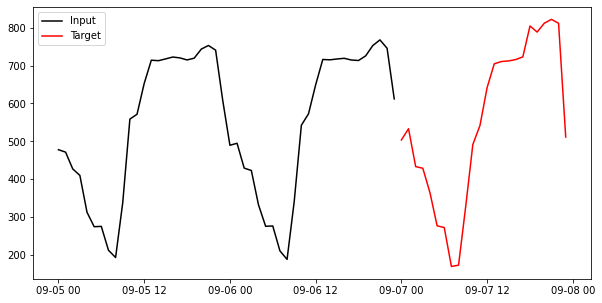

In [69]:
plot_id_info(df, 'MT_353', 'power_usage')

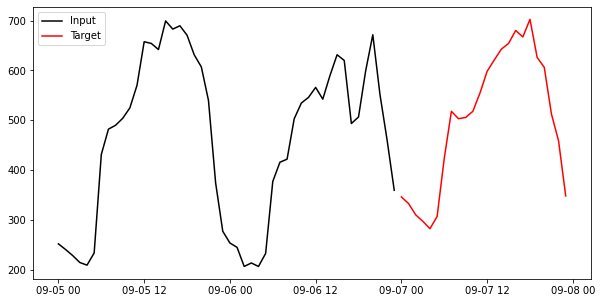

In [70]:
plot_id_info(df, 'MT_178', 'power_usage')

# Datos para Entrenamiento

Este es un problema de pronóstico de múltiples series con un horizonte "múltiple", por lo que este problema se puede atacar de varias formas: 
1. Pronosticar directamente las 24 horas
2. Pronosticar una hora a la vez e ir moviendo la información
3. Pronosticar una hora a la vez utilizando autoregresivamente las predicciones

Vamos a ir por el primero. 

En TensorFlow tenemos formas de entrenar modelos para series de tiempo del mismo individuo, pero en este caso tenemos 370 individuos difernetes.



## Aproximación por Ventanas

[Gráfico de TensorFlow para el pronóstico usando Ventanas]

In [24]:
class processElectricityDataFrame:
    """
    Procesa el DataFrame para generar un data set de ventanas.
    """
    
    def __init__(self, train_df, val_df, test_df, index_variable, target_variable,
                input_window, output_window):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df   
        
        self.label_name = target_variable
        self.input_window = input_window
        self.output_window = output_window
        self.index_variable = index_variable
        
        
        self.model_columns = None # Variables de la ventana
            
    
    def create_npy_dataset(self, df, folder, name, columns, input_window, output_window, label_name):
        """
            df: DataFrame a utilizar
            folder: Folder para almacenar el .npy
            columns: Lista de las columnas que se utilizarán al final
            name: Nombre para el archivo (train, val, test)
            input_window: Tamaño de la ventana de entrada (12)
            output_window: Tramaño de la ventana de salida (12)
            label_name: Nombre de la variable objetivo
        
        """
        file_input = os.path.join(folder, f'input_{name}.npy')
        file_output = os.path.join(folder, f'output_{name}.npy')

        unique_id_names = df[self.index_variable].value_counts().index.values
        npy_input = None
        npy_output = None

        label_index = columns.index(label_name)
        input_columns = columns.copy()
            
        window_size = input_window + output_window
        
        print(f'Started .npy creation with name: {name}')
        for id_name in tqdm(unique_id_names):
            
            customer_df = df[df[self.index_variable] == id_name].sort_values(by = 'date').copy()
            output_tmp_df = customer_df[columns].values
            input_tmp_df = customer_df[input_columns].values
            n_windows = len(output_tmp_df) - window_size + 1
            
            input_array = np.expand_dims(np.arange(self.input_window), 0) +  np.expand_dims(np.arange(n_windows, step = 24), 0).T
            output_array = np.expand_dims(np.arange(self.output_window), 0) + self.input_window +  np.expand_dims(np.arange(n_windows, step = 24), 0).T
            
            
            inputs = input_tmp_df[input_array].astype(np.float32)
            labels = output_tmp_df[output_array, label_index].astype(np.float32)
            
            if npy_input is None:
                
                npy_input = inputs
                npy_output = labels
            else:
                
                npy_input = np.append(npy_input, inputs, axis = 0)
                npy_output = np.append(npy_output, labels, axis = 0)
                
                random_index = np.random.choice(npy_input.shape[0], npy_input.shape[0], replace=False)
                
                npy_input = npy_input[random_index, :, :]
                npy_output = npy_output[random_index, :]
                
        

        with open(file_input, 'wb') as f:
            np.save(f, npy_input)

        with open(file_output, 'wb') as f:
            np.save(f, npy_output)

        print('Completed .npy creation.')        

        
    def preprocess_fn(self, df, model_type):      
        if model_type == 'raw_inf':
            df[self.label_name] = np.log(df[self.label_name] + 1)
            self.model_columns = [self.label_name]#, 'hour', 'day_of_week', 'month']
            return df
        

        
    def create_all_datasets(self, folder_name = 'data', model_type = 'raw_inf'):
        train_df = self.preprocess_fn(self.train_df, model_type)    
         
        self.create_npy_dataset(df = train_df, folder = folder_name, name = 'train', columns =  self.model_columns,
                               input_window = self.input_window, output_window = self.output_window, label_name = self.label_name)
        
        val_df = self.preprocess_fn(self.val_df, model_type)    
         
        self.create_npy_dataset(df = val_df, folder = folder_name, name = 'val', columns =  self.model_columns,
                               input_window = self.input_window, output_window = self.output_window, label_name = self.label_name)
        
        
        test_df = self.preprocess_fn(self.test_df, model_type)    
         
        self.create_npy_dataset(df = test_df, folder = folder_name, name = 'test', columns =  self.model_columns,
                               input_window = self.input_window, output_window = self.output_window, label_name = self.label_name)

In [25]:
test_df = df[df.date >= '2014-08-31']
val_df = df[(df.date >= '2014-08-24') & (df.date < '2014-08-31')]
train_df = df[df.date < '2014-08-24']


In [26]:
train_df.categorical_id.value_counts()

MT_244    984
MT_211    984
MT_204    984
MT_074    984
MT_038    984
         ... 
MT_157    984
MT_004    984
MT_361    984
MT_021    984
MT_178    888
Name: categorical_id, Length: 369, dtype: int64

In [27]:
df_process = processElectricityDataFrame(train_df, 
                                         val_df, 
                                         test_df, 
                                         index_variable = 'categorical_id',
                                         target_variable = 'power_usage',
                                         input_window = 48,
                                         output_window = 24)

In [28]:
df_process.create_all_datasets(folder_name = 'data', model_type = 'raw_inf')

<ipython-input-24-868a10b44aff>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[self.label_name] = np.log(df[self.label_name] + 1)


Started .npy creation with name: train


100%|██████████| 369/369 [00:08<00:00, 44.88it/s]


Completed .npy creation.
Started .npy creation with name: val


100%|██████████| 369/369 [00:01<00:00, 200.93it/s]


Completed .npy creation.
Started .npy creation with name: test


100%|██████████| 369/369 [00:02<00:00, 166.31it/s]

Completed .npy creation.


In [29]:
train_input_example = np.load('data/input_train.npy')
train_output_example = np.load('data/output_train.npy')

In [30]:
train_input_example.shape

(14387, 48, 1)

In [31]:
train_output_example.shape

(14387, 24)

In [85]:
#df[df.categorical_id == 'MT_178'][['date', 'lag_usage']].head(25)

In [86]:
#train_input_example[0, :, :]

In [87]:
#train_output_example[0, :]

# Entrenamiento de Modelo

In [32]:
from datetime import datetime

In [33]:
def load_dataset(path_to_features, path_to_labels):
    features = np.load(path_to_features)
    labels = np.load(path_to_labels)
    
    assert features.shape[0] == labels.shape[0]
    dataset = tf.data.Dataset.from_tensor_slices((features, labels)).batch(128)
    return dataset

In [34]:
train_features = os.path.join('data', 'input_train.npy')
train_labels = os.path.join('data', 'output_train.npy')
train_dataset = load_dataset(train_features, train_labels)

val_features = os.path.join('data', 'input_val.npy')
val_labels = os.path.join('data', 'output_val.npy')
val_dataset = load_dataset(val_features, val_labels)

test_features = os.path.join('data', 'input_test.npy')
test_labels = os.path.join('data', 'output_test.npy')
test_dataset = load_dataset(test_features, test_labels)

In [35]:
def validate_inf(arrays):
    for array in arrays:
        loaded_array = np.load(os.path.join(array))
        n_inf = np.isinf(loaded_array).sum()
        if n_inf:
            print(f'Array {array} contains INF values')
            
        n_nan = np.isnan(loaded_array).sum()
        if n_nan:
            print(f'Array {array} contains NAN values')

In [36]:
validate_inf([train_features, train_labels, val_features, val_labels])

In [37]:
np.load(val_labels).max()

12.03232

In [38]:
np.isnan(np.load(val_labels)).sum()

0

In [39]:
model = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'),
                tf.keras.layers.Dropout(0.05),
                tf.keras.layers.LSTM(32, return_sequences=True, activation='relu'),
                tf.keras.layers.Dropout(0.05),
                tf.keras.layers.LSTM(16, return_sequences=False, activation='relu'),
                tf.keras.layers.Dropout(0.05),
                tf.keras.layers.Dense(24),
                ])

In [40]:

checkpoint_folder = 'training/'
tf_log_dir = 'training/logs'

if not os.path.exists(tf_log_dir):
    os.mkdir(tf_log_dir)
if not os.path.exists(checkpoint_folder):
    os.mkdir(checkpoint_folder)

In [43]:
name = 'random_dropout_0.05'
execution_time = datetime.now().strftime("%Y%m%d-%H%M%S")
tf_log_dir = 'training'
logdir = f"{tf_log_dir}/arbitrary/{name}_{execution_time}" 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

checkpoint_path = f"{checkpoint_folder}/checkpoints_{name}_{execution_time}/cp.ckpt"
checkpoints_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)


earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [44]:
optimizer = tf.optimizers.Adam(learning_rate=0.001)
EPOCHS = 200
model.compile(
      optimizer=optimizer,
      loss=tf.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()],
    )

In [45]:
model.fit(train_dataset, validation_data=val_dataset, 
              callbacks=[tensorboard_callback, checkpoints_callback, earlystopping_callback],
              epochs=EPOCHS, verbose =1) 
    

Epoch 1/200
  1/113 [..............................] - ETA: 0s - loss: 701.4067 - root_mean_squared_error: 26.4841 - mean_absolute_error: 8.0668WARNING:tensorflow:From /Users/jcobapuerto/Library/Python/3.8/lib/python/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
113/113 [==============================] - ETA: 0s - loss: 22.6829 - root_mean_squared_error: 4.7627 - mean_absolute_error: 3.3053
Epoch 00001: val_loss improved from inf to 3.15530, saving model to training//checkpoints_random_dropout_0.05_20220509-150941/cp.ckpt
113/113 [==============================] - 6s 55ms/step - loss: 22.6829 - root_mean_squared_error: 4.7627 - mean_absolute_error: 3.3053 - val_loss: 3.1553 - val_root_mean_squared_error: 1.7763 - val_mean_absolute_error: 1.1070
Epoch 2/200
113/113 [==============================] - ETA: 0s

112/113 [============================>.] - ETA: 0s - loss: 0.3852 - root_mean_squared_error: 0.6207 - mean_absolute_error: 0.4422
Epoch 00017: val_loss did not improve from 0.16091
113/113 [==============================] - 6s 50ms/step - loss: 0.3850 - root_mean_squared_error: 0.6205 - mean_absolute_error: 0.4422 - val_loss: 0.1658 - val_root_mean_squared_error: 0.4072 - val_mean_absolute_error: 0.2880
Epoch 18/200
113/113 [==============================] - ETA: 0s - loss: 0.3819 - root_mean_squared_error: 0.6180 - mean_absolute_error: 0.4415
Epoch 00018: val_loss did not improve from 0.16091
113/113 [==============================] - 6s 51ms/step - loss: 0.3819 - root_mean_squared_error: 0.6180 - mean_absolute_error: 0.4415 - val_loss: 0.1867 - val_root_mean_squared_error: 0.4321 - val_mean_absolute_error: 0.3122
Epoch 19/200
113/113 [==============================] - ETA: 0s - loss: 0.3778 - root_mean_squared_error: 0.6147 - mean_absolute_error: 0.4419
Epoch 00019: val_loss did not 

In [46]:
model.evaluate(test_dataset)

18/18 [==============================] - 0s 16ms/step - loss: 0.2156 - root_mean_squared_error: 0.4643 - mean_absolute_error: 0.3599


[0.21556183695793152, 0.46428635716438293, 0.3598743975162506]

In [47]:
model.evaluate(val_dataset)

15/15 [==============================] - 0s 15ms/step - loss: 0.2139 - root_mean_squared_error: 0.4625 - mean_absolute_error: 0.3649


[0.21389378607273102, 0.46248650550842285, 0.36485910415649414]

In [60]:
X = np.load(test_features)
Y = np.load(test_labels)

In [61]:
Y_hat = model.predict(X)

In [122]:
def plot_predictions(Y_past, Y_true, Y_pred, idx_obs, exponent = True):
    plt.figure(figsize = (10, 5))
    input_length = Y_past.shape[1]
    ouput_length = Y_pred.shape[1]
    if not exponent:
        plt.plot(np.arange(input_length), Y_past[idx_obs, :, 0], color = 'black')
        plt.plot(np.arange(input_length, input_length+ouput_length), Y_true[idx_obs,: ], color = 'black', label = 'True Usage', linestyle = '--')
        plt.plot(np.arange(input_length, input_length+ouput_length), Y_pred[idx_obs, :], color = 'red', label = 'Prediction')
    else:
        plt.plot(np.arange(input_length), np.exp(Y_past[idx_obs, :, 0]) - 1, color = 'black')
        plt.plot(np.arange(input_length, input_length+ouput_length), np.exp(Y_true[idx_obs,: ]) - 1, color = 'black', label = 'True Usage', linestyle = '--')
        plt.plot(np.arange(input_length, input_length+ouput_length), np.exp(Y_pred[idx_obs, :]) - 1, color = 'red', label = 'Prediction')
    plt.legend()

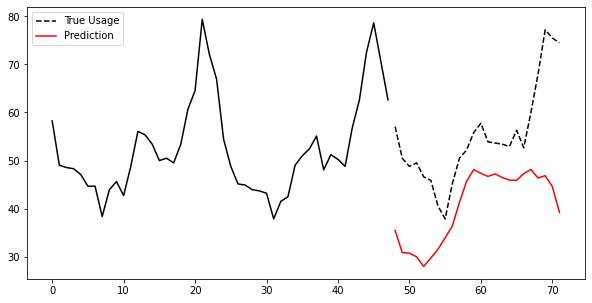

In [123]:
plot_predictions(X, Y, Y_hat, 2)

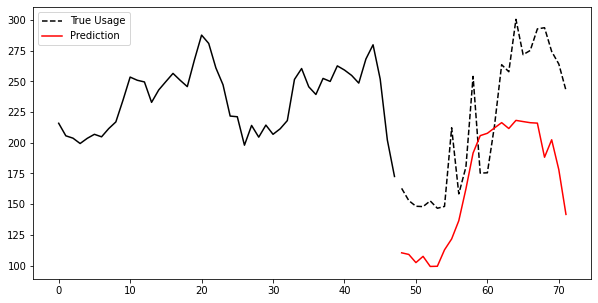

In [124]:
plot_predictions(X, Y, Y_hat, 13)

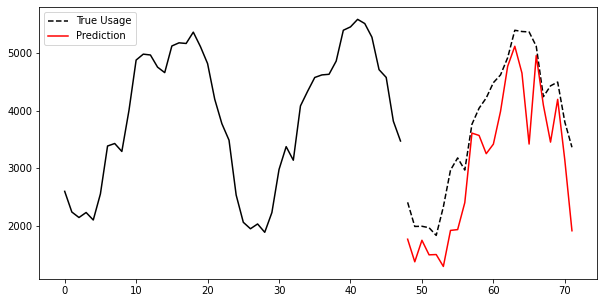

In [125]:
plot_predictions(X, Y, Y_hat, 41)